# 4IM01 - Skin Lesions - Giordmaina - Bonninière

In [13]:
from display_image import viewimage, viewimgs, view3imgs
import cv2
from test_otsu_simple import display_otsu_simple
from test_otsu_prepro1 import display_otsu_prepro1
from dull_razor import dull_razor

## Objectif 
Le projet s'intéresse à l'analyse d'images dermatologiques de lésion cutanées. Le but est de créer un pipeline prenant en entrée une image dermatologique présentant une lésion et d'obtenir le masque binaire de cette lésion pour permettre l'analyse par des médecins. Les images que nous analysons sont toutes du même types. La lésion est toujours située au centre de l'image. On cherche donc à utiliser une méthode de segmentation pour obtenir le masque binaire de chaque lésion. 

### Position du problème de la segmentation :

L'un des enjeux de l'analyse de ce type d'image dermatologique est que l'acquisition n'est jamais identique et que notre pipeline doit s'adapter à tous les différents types de peaux et de lésions. En effet, les images sont diverses, et présentent des contrastes variés. Ainsi, on peut retrouver des zones sombres qui compliquent l'application de la segmentation. Certaines lésions sont plus ou moins marquées et contrastées ce qui peut empêcher une segmentation facile. La présence de poils est aussi un des enjeux de la segmentation puisqu'ils gênent l'identification de la lésion en elle-même. 

Les images ci-dessous montrent cette pluralité au sein des images dermatologiques que l'on considére : 
 

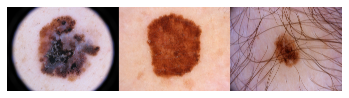

In [2]:
img4, img7, img19 = cv2.imread('images_test/img4.jpg'), cv2.imread('images_test/img7.jpg'), cv2.imread('images_test/img19.jpg')
view3imgs(img4, img7, img19)

### Organisation du pipeline

Le pipeline mis en oeuvre pour obtenir les masques binaires de segmentation des lésions cutanées se divisent en trois parties distinctes : le pre-processing, la segmentation et le post-processing.

#### Pre-processing : 

Les étapes de pre-processing ont pour objectif de "nettoyer" l'image originale pour améliorer la qualité de l'output de l'algortihme de segmentation qui sera ensuite appliqué à l'image dermatologique. On distingue deux sous-étapes dans ce pré-traitement de l'image : le _black frame removal_ et le _hair removal_. 

En effet, certaines images présentent des zones sombres ou noires dans les coins qui interférent avec les algorithme de _hair removal_ et de segmentation. Le premier défi est donc de venir sélectionner ces zones noires, les blacks frames, pour ne pas les prendre en compte dans la suite du traitement au sein du pipeline. 

Ensuite, on cherche à retirer les potentiels poils présents sur les images car ceux-ci sont sombres et interfèrent fortement avec les lésions qui sont, elles aussi, sombres. 


#### Méthode de segmentation d'Otsu :

Pour mieux comprendre pourquoi le pre-processing est primordial, il est d'abord nécessaire de s'attarder sur la méthode de segmentation que nous avons utilisée. Il s'agit de la méthode de segmentation d'Otsu qui permet une segmentation binaire entre 2 classes (parties distinctes de l'image) et qui repose sur la maximisation de la variance inter-classe. On fixe un certain seuil de niveau de gris puis, en définissant la variance de chaque classe puis la variance inter-classe, on cherche le seuil qui va maximiser cette dernière variance. On peut alors appliquer un seuillage binaire à l'image pour obtenir un masque binaire. Du fait de cette binarisation par recherche d'un seuil permettant de séparer l'image en deux parties, on remarque que l'impact des poils et des _black frames_ est très important puiqu'ils interfèrent lors de la définition des deux classes qui initialement doivent être la peau (classe C0) et la lésion (classe C1). 


## Segmentation par Otsu : 

Pour se rendre compte de l'interêt de l'intégralité du pipeline, on s'intéresse en premier lieu à notre méthode de segmentation seule, Otsu. Comme déja mentionné précédemment, elle repose sur la définition de deux classes à l'aide d'un seuil de niveau de gris permettant de maximiser la variance inter-classe. La segmentation par Otsu est développée dans le module `otsu_seg.py`. Pour la méthode d'Otsu, on passe l'image de départ en niveaux de gris avec la fonction `cvtColor` et son attribut `cv2.COLOR_BGR2GRAY` du module `cv2`.

Dans un premier temps, on calcule l'histogramme de l'image avec `calcHist` de `cv2`. Puis, on normalise l'histogramme pour avoir la probabilité d'apparition de chaque niveau de gris, avec la fonction `prob_gray_lvl`. On est alors en mesure de calculer la probabilité de chaque classe et sa moyenne en fonction du seuil t, et finalement la variance inter-classe toujours en fonction de t à l'aide de la fonction `var_between_class`. C'est cette variance qu'on maximise dans la fonction `otsu` qui fournit le seuil correspondant. C'est avec cette valeur de seuil qu'on applique le seuillage binaire ensuite. 

```python 
def otsu(img,mask):
    var_max = 0
    tresh = 0
    for i in range(N):
        var = var_between_class(img,mask,i)
        if var > var_max:
            var_max = var
            tresh = i
    return tresh
```
Or on remarque que si la méthode de segmentation d'Otsu fonctionne bien pour des images "propres" avec un bon contraste et une lésion cutanée nette, sans poil et sans bords noirs, ce n'est pas le cas pour toutes les autres images de lésions. En effet, pour les images propres, on obtient un bon score de Dice proche de 1 (cf. image 7 avec un dice de 0.98). En revanche, si l'image comporte des black frames, on les retrouve dans le masque binaire réalisé par Otsu ce qui fait automatiquement baissé le score du dice (cf. image 1 avec un dice de 0.51 ou encore image 19 avec un dice de 0.42). On présente ci-contre les masques binaires respectifs des images 1, 7 et 19 obtenus par Otsu seul : 

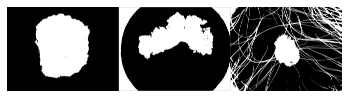

In [3]:
img1 , img7, img19 = cv2.cvtColor(cv2.imread('images_test/img1.jpg'), cv2.COLOR_BGR2GRAY), cv2.cvtColor(cv2.imread('images_test/img7.jpg'), cv2.COLOR_BGR2GRAY), cv2.cvtColor(cv2.imread('images_test/img19.jpg'), cv2.COLOR_BGR2GRAY)
res1, res7, res19 = display_otsu_simple(img1), display_otsu_simple(img7), display_otsu_simple(img19)
view3imgs(res7, res1, res19) 

Maintenant que le besoin d'un pré-traitement sur nos images est clair, il convient de montrer la nécessité du post-processing pour pouvoir obtenir les meilleurs masques des lésions possibles. En effet, même si la segmentation est déjà satisfaisante dans le cas d'images sans poils et sans bords noirs, on se rend compte que le masque de la lésion (partie blanche n'est pas uniforme). Il faut appliquer des méthodes de post-traitement pour remédier à ses aterfacts indésirables de la segmentation par Otsu. Ci-contre des exemples de ces artefacts indésirables sur des masques déjà satisfaisants après les deux premières étapes du pipeline (cf. image 5 et image 6) : 

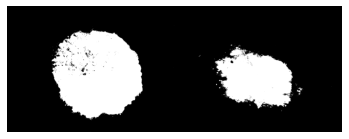

In [4]:
img5, img6 = cv2.cvtColor(cv2.imread('images_test/img5.jpg'), cv2.COLOR_BGR2GRAY), cv2.cvtColor(cv2.imread('images_test/img6.jpg'), cv2.COLOR_BGR2GRAY)
res5, res6 = display_otsu_simple(img5), display_otsu_simple(img6)
viewimgs(res5, res6)

## Pre-processing : 

### Black frames removal : 

Dans cette partie du pre-processing, on s'intéresse aux images qui présentent des bords noirs ou des zones sombres qui doivent être "enlevés" ou du moins identifiés pour ne pas être pris en compte dans la suite du pipeline. Pour venir sélectionner ces zones indésirables de l'image, on travaille par _region growing_. 

Dans les quatres coins de l'image on vérifie sur quatres sets de pixels carrés (dont la taille et la position sont des paramètres) qu'il y a des zones noires. Pour vérifier que ces sets de pixels sont noirs, on calcule leur moyenne et on compare cette valeur à un certain _tau_ (seuil qui est aussi un paramètre du pipeline). Après plusieurs essais et pour bien enlever toutes les zones noires, même diffuses, on fixe le **seuil à 150**. Si l'image n'a pas de zones noires alors cette étape n'est pas nécessaire et on retourne donc l'image originale pour continuer le pipeline. En revanche, si on trouve des sets noirs dans les coins de l'image, on démarre le processus de _region growing_. A partir de chaque set de pixels, on initialise une liste d'attente des pixels noirs à visiter et une liste rassemblant toutes les coordonnées des pixels noirs qui ont déja été visités. En parcourant chaque voisin de chaque pixel noir identifié, toujours définis comme étant les pixels inférieurs à un certain seuil _tau_, on peut alors rassembler de proche en proche tous les pixels noirs indésirables situés sur les bords de notre image. 


Une fois que tous les pixels noirs des bords de notre image ont été visités, leurs coordonées sont retournées sous forme d'un masque qui va permettre de ne pas les prendre en compte dans les autres étapes du pipeline. Ce masque est renvoyé par la fonction `mask_remove` du module `blk_removal.py`. Les pixels à ne pas prendre en compte sont marqués comme **False** et les pixels à prendre en compte (qui constituent la partie de l'image à étudier) sont marqués comme **True**. 

En appliquant le _black frame removal_ on obtient un meilleur masque de segmentation de la lésion cutanée. Ci-contre l'image originale en niveaux de gris et les masques obtenus respectivement avec une segmentation simple et avec le pre-processing avant la segmentation (pour l'image 4) : 

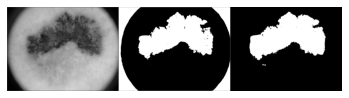

In [ ]:

img4 = cv2.cvtColor(cv2.imread('images_test/img1.jpg'), cv2.COLOR_BGR2GRAY)
tau,l,x,y = 150,5,10,10 
res4, res4_prime = display_otsu_simple(img4), display_otsu_prepro1(img4,tau,l,x,y)
tau,l,x,y = 150,5,10,10
view3imgs(img4, res4, res4_prime)

### Dull razor : 

Dans cette partie du pré-processing, on s’intéresse à la partie _hair remover_ qui consiste à enlever les poils de la photo. On commence par appliquer à l’image RGB un filtre gaussien pour flouter en partie le mélanome et éviter de perdre trop sa texture à la sortie de `dull_razor`. Ensuite, on applique une fermeture morphologique sur les canaux rouge vert et bleu successivement, avec pour élément structurant des lignes de 0°, 90°, 45° et 135°, pour essayer de trouver un maximum de direction des poils dans l’image. On soustrait cette dernière image à l’image initiale de chaque canal pour obtenir le mask en choisissant à chaque étape le maximum (maximum pour les directions dans chaque canal couleur séparé et maximum dans les canaux couleurs pour le mask final). Ce masque sera donc notre référence lorsqu’on applique la fonction inpaint d’openCV sur l’image non floutée initiale.

Les résultats obtenus sont satisfaisants, mais on observe une perte d’information au niveau du mélanome. Pour cela on propose au clinicien une option grâce à laquelle il choisit ou non d’enlever les poils.



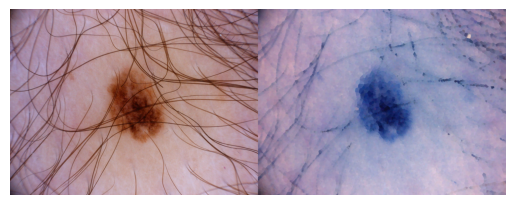

In [5]:
img1 = 'images_test/img19.jpg'
img1_d = dull_razor(img1)
viewimgs(cv2.imread(img1), img1_d)

## Post-processing : 

Pour la dernière étape du pipeline, il s'agit de venir lisser le résultat obtenu après le pre-processing et la segmentation par Otsu pour ne récupérer comme masque que la lésion sous forme d'une unique composante connexe. 

Pour pouvoir combler les trous indésirables dans notre image, on utilise les outils de morpho maths compris dans la blibliothèthe `skimage.morphology`. Cette étape applique une ouverture par un un élément structurant disque dont la taille est à déterminer afin d'obtenir un résultat optimal. Après de nombreux essais, ce paramètre est fixé à **20 pixels**. L'ouverture permet de combler les trous noirs de la lésion dans le masque binaire tout en conservant la forme initiale de l'image. En effet, l'ouverture est une fermeture suivi d'une dilatation par le même élément structurant, ici le disque. 

Une fois que cette étape de nettoyage des trous est finalisée, il reste à ne conserver qu'une unique composante connexe pour le masque de la lésion. Pour ce faire, on cherche les composantes connexes dans notre masque et on garde la plus grande. Cette étape est réalisée par la fonction `find_largest_connected_component`du module `find_central_component.py`. On est ainsi en mesure d'afficher un unique masque pour la lésion. Si cela permet d'améliorer le Dice dans de nombreux cas, la recherche de composante connexe principale n'est pas optimale si la segmentation par Otsu à séparer le masque de la lésion en deux parties distinctes, comme dans le cas de l'image 9. Ci-contre l'image 9 avec une segmentation simple qui sépare la lésion et le masque après l'ouverture et la recherche de plus grande composante connexe :

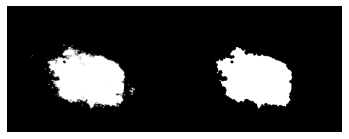

In [17]:
from post_processing import opening
import skimage.morphology as morph
from find_central_component import find_largest_connected_component
i=20
img9, mask9= cv2.cvtColor(cv2.imread('images_test/img6.jpg'), cv2.COLOR_BGR2GRAY), cv2.cvtColor(cv2.imread('images_test/msk6.png'), cv2.COLOR_BGR2GRAY)
res9, res9_prime = display_otsu_prepro1(img9,tau,l,x,y), find_largest_connected_component(display_otsu_prepro1(opening(img9,morph.disk(i)),tau,l,x,y))
viewimgs(res9, res9_prime)

In [8]:
from main_test import table_score, D

table_score(D)

| Image | Otsu | Otsu + Pre-processing 1 | Otsu + Post-processing 1 | Otsu + Pre-processing 1 + Post-processing 1 
| --- | --- | --- | --- | --- 
| Image 1 | 0.5134209823144532 | 0.6320512425307814 | 0.6146342345066003 | 0.6456765890735732 |
| Image 2 | 0.8436236464093941 | 0.8917028910478629 | 0.8883692679034352 | 0.9398273721813645 |
| Image 3 | 0.5942052940741882 | 0.5942052940741882 | 0.6710225835485408 | 0.6710225835485408 |
| Image 4 | 0.5744715554050264 | 0.8605290977280661 | 0.8352550686032008 | 0.8801608899455436 |
| Image 5 | 0.8779847726195018 | 0.8779847726195018 | 0.9028245711955625 | 0.9028245711955625 |
| Image 6 | 0.7009878098677075 | 0.7009878098677075 | 0.7458707410718605 | 0.7458707410718605 |
| Image 7 | 0.9866045254550194 | 0.9866045254550194 | 0.9931997342582581 | 0.9931997342582581 |
| Image 8 | 0.8752530381450363 | 0.9109996676556317 | 0.9409382554021878 | 0.9417812713540322 |
| Image 9 | 0.7971805809321781 | 0.7971805809321781 | 0.8094126007548516 | 0.8094126007548516 |
| Image 10 | 0.8083436896545131 | 0.8083436896545131 | 0.8600275238088266 | 0.8600275238088266 |
| Image 11 | 0.9267625639057613 | 0.9267625639057613 | 0.9347103011338675 | 0.9347103011338675 |
| Image 12 | 0.9796347984625072 | 0.9796347984625072 | 0.9755737991910145 | 0.9755737991910145 |
| Image 13 | 0.9309017778858711 | 0.9309017778858711 | 0.9513095849105023 | 0.9513095849105023 |
| Image 14 | 0.8590606920837974 | 0.8590606920837974 | 0.9008600857260479 | 0.9008600857260479 |
| Image 15 | 0.0 | 0.0 | 0.0 | 0.0 |
| Image 16 | 0.7545538243487034 | 0.7545538243487034 | 0.7709545613015688 | 0.7709545613015688 |
| Image 17 | 0.5156797709360423 | 0.8609673681975024 | 0.0 | 0.8846288874086413 |
| Image 18 | 0.9402448642977528 | 0.9402448642977528 | 0.9612146032734099 | 0.9612146032734099 |
| Image 19 | 0.41579751544542615 | 0.009231687340531128 | 0.3148755446655625 | 0.00033616638774600435 |
| Image 20 | 0.6714143625820211 | 0.7305599584735316 | 0.7702826798842546 | 0.7547407222190855 |


### Tentative d'amélioration : Otsu_level 

On remarque que tous les étapes de notre pipeline permettent d'augmenter le Dice de notre masque binaire. Cependant, pour certaines images notamment avec des lésions possèdant de niveaux de couleur, on remarque que Otsu simple est limitée et ne permet pas une segmentation complète. Parfois le masque de la lésion est tronqué ou bien coupé en deux (cf. respectivement images 9 et 10). Pour remédier à ce problème et améliorer globalement les scores de Dice, on peut adapter la méthode d'Otsu simple opérant sur une image en niveau de gris à des images couleurs. Cette opération est réalisée dans la fonction `display_otsu_level` du module `otsu2.py`. Pour ce faire, on peut décomposer l'image couleur en quatres sous images : image en niveaux de gris, image du canal rouge, image du canal bleu et image du canal vert. Ensuite, on applique le pipeline décrit précedemment (pre-processing, Otsu simple et post_processing) à chacune de ces quatres images. On récupère quatres masques que l'on vient superposer (cf. union de tous les masques binaires) pour obtenir le masque final. Cela permet de maximiser les contrastes sur différents canaux de couleur afin d'améliorer le masque final. 

Cependant, le résultat est décevant puique les résultats au global sont de moins bonne qualité que pour la méthode de Otsu simple. 

In [9]:
from main_test import D_lvl, table_score_lvl

table_score_lvl(D_lvl)

| Image | Otsu_level 
| --- | --- 
| Image 1 | 0.6378458282510885 |
| Image 2 | 0.8932540981193757 |
| Image 3 | 0.6108226427918181 |
| Image 4 | 0.8609189296328632 |
| Image 5 | 0.8640363785467936 |
| Image 6 | 0.7090195188839923 |
| Image 7 | 0.9883241448143872 |
| Image 8 | 0.8873684074643728 |
| Image 9 | 0.7552158201718225 |
| Image 10 | 0.7669110718725504 |
| Image 11 | 0.9423174734279567 |
| Image 12 | 0.9694262638785072 |
| Image 13 | 0.9491522018643523 |
| Image 14 | 0.8908092275384032 |
| Image 15 | 0.5787929150953025 |
| Image 16 | 0.9009790254370363 |
| Image 17 | 0.8719948356465334 |
| Image 18 | 0.9816183059508811 |
| Image 19 | 0.0 |
| Image 20 | 0.6453185498813718 |


On peut alors améliorer les résultats obtenus par la méthode d’Otsu en utilisant 2 seuils $t_h$ et $t_s$ pour former un seuil global. L’idée vient du fait qu’avec la méthode d’Otsu, on a peut-être segmenté sur une partie du mélanome, et on voudrait que la segmentation se fasse bien sur la peau.

Pour obtenir les différents seuils, on doit faire une étude sur les caractéristiques de pixels de la peau. On choisit un échantillon de peau d’après certains critères sur la moyenne et l’écart type et on calcule l’image d’intensité ; c’est-à-dire une image qu’on obtient par comparaison avec les éléments médians de la région de peau sélectionnée. 

Pour cela, on veut maximiser à la fois la variance interclasse, mais aussi l’histogramme d’un set de région choisies de manière adéquate. Le seuil en question sera donc le premier seuil : $t_h$. Dans ce cas on choisit la fenêtre de l’image complète et une zone de pixels diagonaux (formant un drapeau du Royaume-Uni).

L’autre seuil $t_s$, se calcule à l’aide des 5ème et 50ème percentiles des valeurs de l’image d’intensité. Une constante beta pondère les deux valeurs. 

On obtient alors : $t = \alpha \cdot t_h + (1 - \alpha) \cdot t_s$ avec la constante alpha qui pondère le seuil final. Et si $t_s > t_h$, ce qui peut être le cas en présence de trop d’artefacts, on pose $\alpha = 1$, et ainsi la valeur de $t_s$ n’influe pas.
On applique alors Otsu à l’image d’intensité avec ce seuil.

Nous avons essayé d'implémenter cette méthode, mais n'avons pas réussi à bébeuger le code...

